# Steane's Code Under Random Pauli Error
**Author:** Julia Cen

## What is the Steane's Code?

One of the major challenges faced in quantum computation is how susceptible quantum states are to errors, for example, from interactions with the environment. One way to tackle this is with quantum error correction codes. In this notebook, we will look at one example called Steane's code. This code was developed by Steane in 1996 [1]. It is a [[7,1,3]] quantum code, a type of Calderbank–Shor–Steane (CSS) code (stabilizers are only of X-type or Z-type) based on the classical [7,4,3] Hamming code. The code encodes 1 logical qubit into 7 physical qubits with code distance 3 (minimum weight/number of Pauli errors of a logical operator such that it commutes with all stabilizers, but is not a stabilizer itself). Steane's code can detect and correct $\frac{d-1}{2}=1$ arbitrary qubit errors.

## Building Steane's Code

We will write Steane's code to help us correct a bit flip (X), phase flip (Z), or bit+phase flip (Y) for each independent qubit in a $|x>$ state formed from a given Boolean string $x\in \mathbb{F}^n_2$.

### The Code Structure

1) Encoding $|x>$ to a logical $|x_L>$ state for Steane's code
2) Run the encoded logical state $|x_L>$ through a Pauli error channel
3) Measure syndromes to find where 1 qubit errors occurred 
4) Apply recovery operations to fix any 1 qubit errors
5) Measure the data qubits and decode the result to see how the recovery went

In [1]:
from qiskit import *
from qiskit.quantum_info import *
from qiskit.circuit.library import *

from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np
import matplotlib.pyplot as plt

### Encoding $|x>$

The Steane's code encodes each qubit into 7 physical qubits. So for the state $|x>$ where $x\in \mathbb{F}_2^n$, we will need $7n$ physical qubits to encode the state. 

Steane's code [2] is defined by the stabilizer group of 6 commuting operators. 3 of X-type and 3 of Z-type

\begin{align*}
M_0 &=X_4X_3X_2X_1, \,\,
M_1=X_5X_3X_2X_0, \,\,
M_2=X_6X_3X_1X_0, \\
N_0&=Z_4Z_3Z_2Z_1, \,\,\,\,\,\,\,
N_1=Z_5Z_3Z_2Z_0, \,\,\,\,\,\,\,
N_2=Z_6Z_3Z_1Z_0.
\end{align*}

For a single qubit basis states $|0>$ and $|1>$, the logical $|x_L>$ states for Steane's code are

\begin{align*}
|0_L> &=\frac{1}{\sqrt{8}} (I+M_0)(I+M_1)(I+M_2)|0>^{\otimes 7}\\
&= \frac{1}{\sqrt{8}}(|0000000>+|1010101>+|0110011>+|1100110>+|0001111>+|1011010>+|0111100>+|1101001>)\\
|1_L> &=\frac{1}{\sqrt{8}} (I+M_0)(I+M_1)(I+M_2)|1>^{\otimes 7}\\
&= \frac{1}{\sqrt{8}}(|1111111>+|0101010>+|1001100>+|0011001>+|1110000>+|0100101>+|1000011>+|0010110>)
\end{align*}

which are just the superpositions of binary basis vectors from codewords of the [7,4,3] Hamming code that have even and odd numbers of 1s, respectively. An important property to note is that logical states are the eigenvectors of the stabilizer operators with eigenvalue 1. This is key for detecting errors later.

$$
M_i|x_L>=N_i|x_L>=|x_L>.
$$

Let us now first prepare the logical state $|x_L>$ given a boolean string $x\in\mathbb{F}^n_2$ [3].

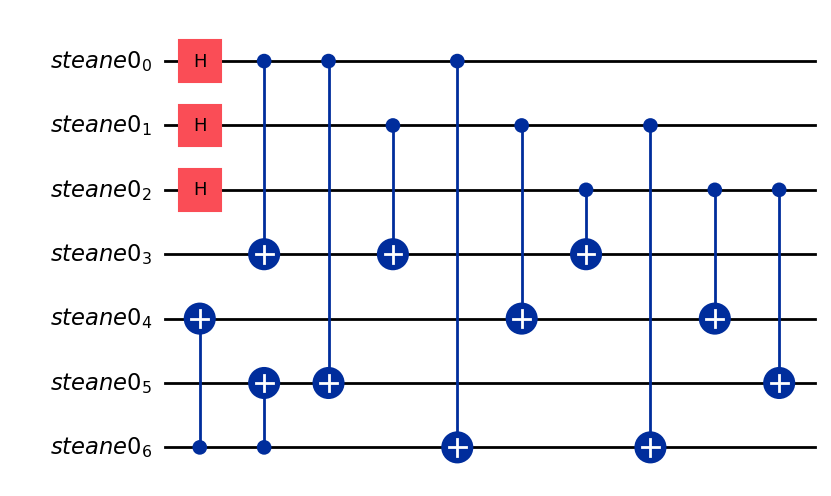

<IPython.core.display.Latex object>

In [2]:
# define a boolean string
xstring = "0"

# length of boolean string
n = len(xstring)

# create a circuit of 7n qubits
steane_qubits = []

for i in range(n):
    qr = QuantumRegister(size=7, name=f"steane{i}")
    steane_qubits.append(qr)

steane_code = QuantumCircuit(*steane_qubits, name="steane_circuit")

def encode(xstring, steane_qubits, steane_code):
    # prepare the logical |x_L> state
    for i, bit in enumerate(xstring):
        if bit == '0':
            steane_code.cx(steane_qubits[i][6],steane_qubits[i][4])
            steane_code.cx(steane_qubits[i][6],steane_qubits[i][5])
            steane_code.h(steane_qubits[i][0])
            steane_code.cx(steane_qubits[i][0],steane_qubits[i][3])
            steane_code.cx(steane_qubits[i][0],steane_qubits[i][5])
            steane_code.cx(steane_qubits[i][0],steane_qubits[i][6])
            steane_code.h(steane_qubits[i][1])
            steane_code.cx(steane_qubits[i][1],steane_qubits[i][3])
            steane_code.cx(steane_qubits[i][1],steane_qubits[i][4])
            steane_code.cx(steane_qubits[i][1],steane_qubits[i][6])   
            steane_code.h(steane_qubits[i][2])
            steane_code.cx(steane_qubits[i][2],steane_qubits[i][3])
            steane_code.cx(steane_qubits[i][2],steane_qubits[i][4])
            steane_code.cx(steane_qubits[i][2],steane_qubits[i][5])
        else:
            steane_code.x(steane_qubits[i][6])
            steane_code.cx(steane_qubits[i][6],steane_qubits[i][4])
            steane_code.cx(steane_qubits[i][6],steane_qubits[i][5])
            steane_code.h(steane_qubits[i][0])
            steane_code.cx(steane_qubits[i][0],steane_qubits[i][3])
            steane_code.cx(steane_qubits[i][0],steane_qubits[i][5])
            steane_code.cx(steane_qubits[i][0],steane_qubits[i][6])
            steane_code.h(steane_qubits[i][1])
            steane_code.cx(steane_qubits[i][1],steane_qubits[i][3])
            steane_code.cx(steane_qubits[i][1],steane_qubits[i][4])
            steane_code.cx(steane_qubits[i][1],steane_qubits[i][6])   
            steane_code.h(steane_qubits[i][2])
            steane_code.cx(steane_qubits[i][2],steane_qubits[i][3])
            steane_code.cx(steane_qubits[i][2],steane_qubits[i][4])
            steane_code.cx(steane_qubits[i][2],steane_qubits[i][5])

    #encodegate = steane_code.to_gate()
    return steane_code

encoder=encode(xstring, steane_qubits, steane_code)
display(steane_code.draw(output="mpl"))
display(Statevector(steane_code).draw(output="Latex"))

### Simulating Noise

Now, we simulate noise by running the encoded logical state $|x_L>$ through a Pauli error channel. This error channel will apply for each qubit, an X,Y or Z error with a given probability $p\leq 3$. In other words:

$$
\mathbb{P}(\text{no error})=1-3p,
$$
$$
\mathbb{P}(\text{X error})=\mathbb{P}(\text{Y error})=\mathbb{P}(\text{Z error})=p.
$$

To create this, we generate a random number r,  between 0 and 1. If the random number is $0\leq r < p$, we apply a X error, $p\leq r < 2p$, we apply a Y error, $2p\leq r < 3p$, we apply a Z error, or no error otherwise.

Qubit <Qubit register=(7, "steane0"), index=0>: No error applied
Qubit <Qubit register=(7, "steane0"), index=1>: Y error applied
Qubit <Qubit register=(7, "steane0"), index=2>: Y error applied
Qubit <Qubit register=(7, "steane0"), index=3>: No error applied
Qubit <Qubit register=(7, "steane0"), index=4>: Z error applied
Qubit <Qubit register=(7, "steane0"), index=5>: Y error applied
Qubit <Qubit register=(7, "steane0"), index=6>: No error applied


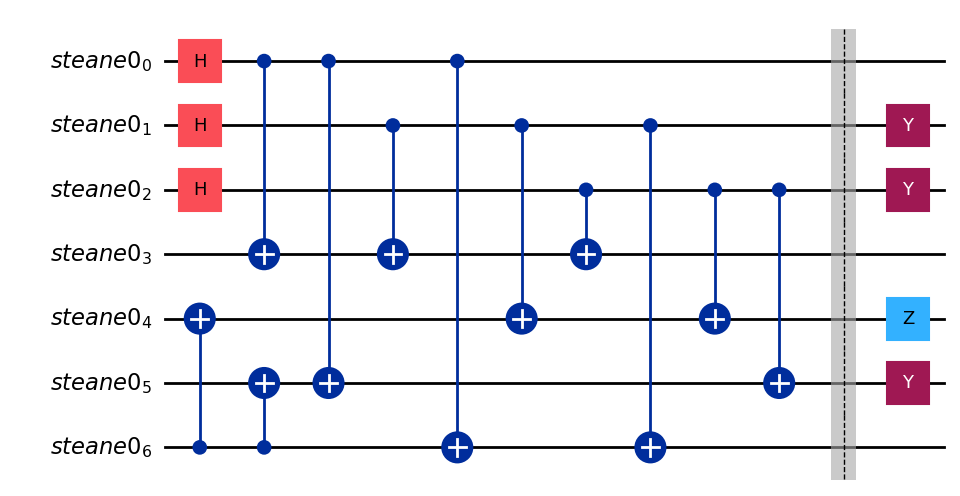

<IPython.core.display.Latex object>

In [3]:
# defining the Pauli error channel 
def error(p, steane_qubits, steane_code):
    for block_index, block in enumerate(steane_qubits):
        for qubit_index, qubit in enumerate(block):
            r = np.random.rand()
            if r < p:
                steane_code.x(qubit)
                print(f"Qubit {qubit}: X error applied")
            elif r < 2*p:
                steane_code.y(qubit)
                print(f"Qubit {qubit}: Y error applied")
            elif r < 3*p:
                steane_code.z(qubit)
                print(f"Qubit {qubit}: Z error applied")
            else:
                print(f"Qubit {qubit}: No error applied")
                
p=0.25                
steane_code = QuantumCircuit(*steane_qubits, name="steane_circuit")
encode(xstring, steane_qubits, steane_code)
steane_code.barrier()
error(p, steane_qubits, steane_code)
display(steane_code.draw(output="mpl"))
display(Statevector(steane_code).draw(output="Latex"))

### Error Detection for 1 Qubit Errors

Now we want to measure the syndromes to find where 1 qubit errors occurred. Let us first define the parity check matrix coming from the [7,4,3] Hamming code which are the same for both X and Z errors

$$
H_X=H_Z=\begin{pmatrix}
0 & 0 & 0 & 1 & 1 & 1 & 1\\
0 & 1 & 1 & 0 & 0 & 1 & 1\\
1 & 0 & 1 & 0 & 1 & 0 & 1
\end{pmatrix}.
$$

The columns are syndromes for the corresponding $X,Z$ errors that help us to decode. Below are syndrome to $X,Z$ error recipe:

\begin{align}
    \begin{pmatrix} 0 \\ 0 \\ 0 \end{pmatrix}   &\mapsto \text{no 1 qubit error} \\
    \begin{pmatrix} 1 \\ 0 \\ 0 \end{pmatrix}   &\mapsto X_0, Z_0 \\
    \begin{pmatrix} 0 \\ 1 \\ 0 \end{pmatrix}   &\mapsto X_1, Z_1 \\
    \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}   &\mapsto X_2, Z_2 \\
    \begin{pmatrix} 1 \\ 1 \\ 0 \end{pmatrix}   &\mapsto X_3, Z_3 \\
    \begin{pmatrix} 0 \\ 1 \\ 1 \end{pmatrix}   &\mapsto X_4, Z_4 \\
    \begin{pmatrix} 1 \\ 0 \\ 1 \end{pmatrix}   &\mapsto X_5, Z_5 \\
    \begin{pmatrix} 1 \\ 1 \\ 1 \end{pmatrix}   &\mapsto X_6, Z_6 \\
\end{align}

Note $Y=iXZ$, so Y errors can also be detected and corrected. For each logical qubit, we introduce 3 ancilla qubits for the X syndrome checks and 3 ancilla qubits for the Z syndrome checks. We write a code with controlled X and X gates to collect the parity of bit and phase flips, make measurements, and store them on classical bits. The rows of the parity check matrix are the stabilizers, which tell us which qubits to make the controls, and they act on the corresponding target ancillas.


Qubit <Qubit register=(7, "steane0"), index=0>: Y error applied
Qubit <Qubit register=(7, "steane0"), index=1>: X error applied
Qubit <Qubit register=(7, "steane0"), index=2>: Z error applied
Qubit <Qubit register=(7, "steane0"), index=3>: Y error applied
Qubit <Qubit register=(7, "steane0"), index=4>: No error applied
Qubit <Qubit register=(7, "steane0"), index=5>: Z error applied
Qubit <Qubit register=(7, "steane0"), index=6>: Y error applied


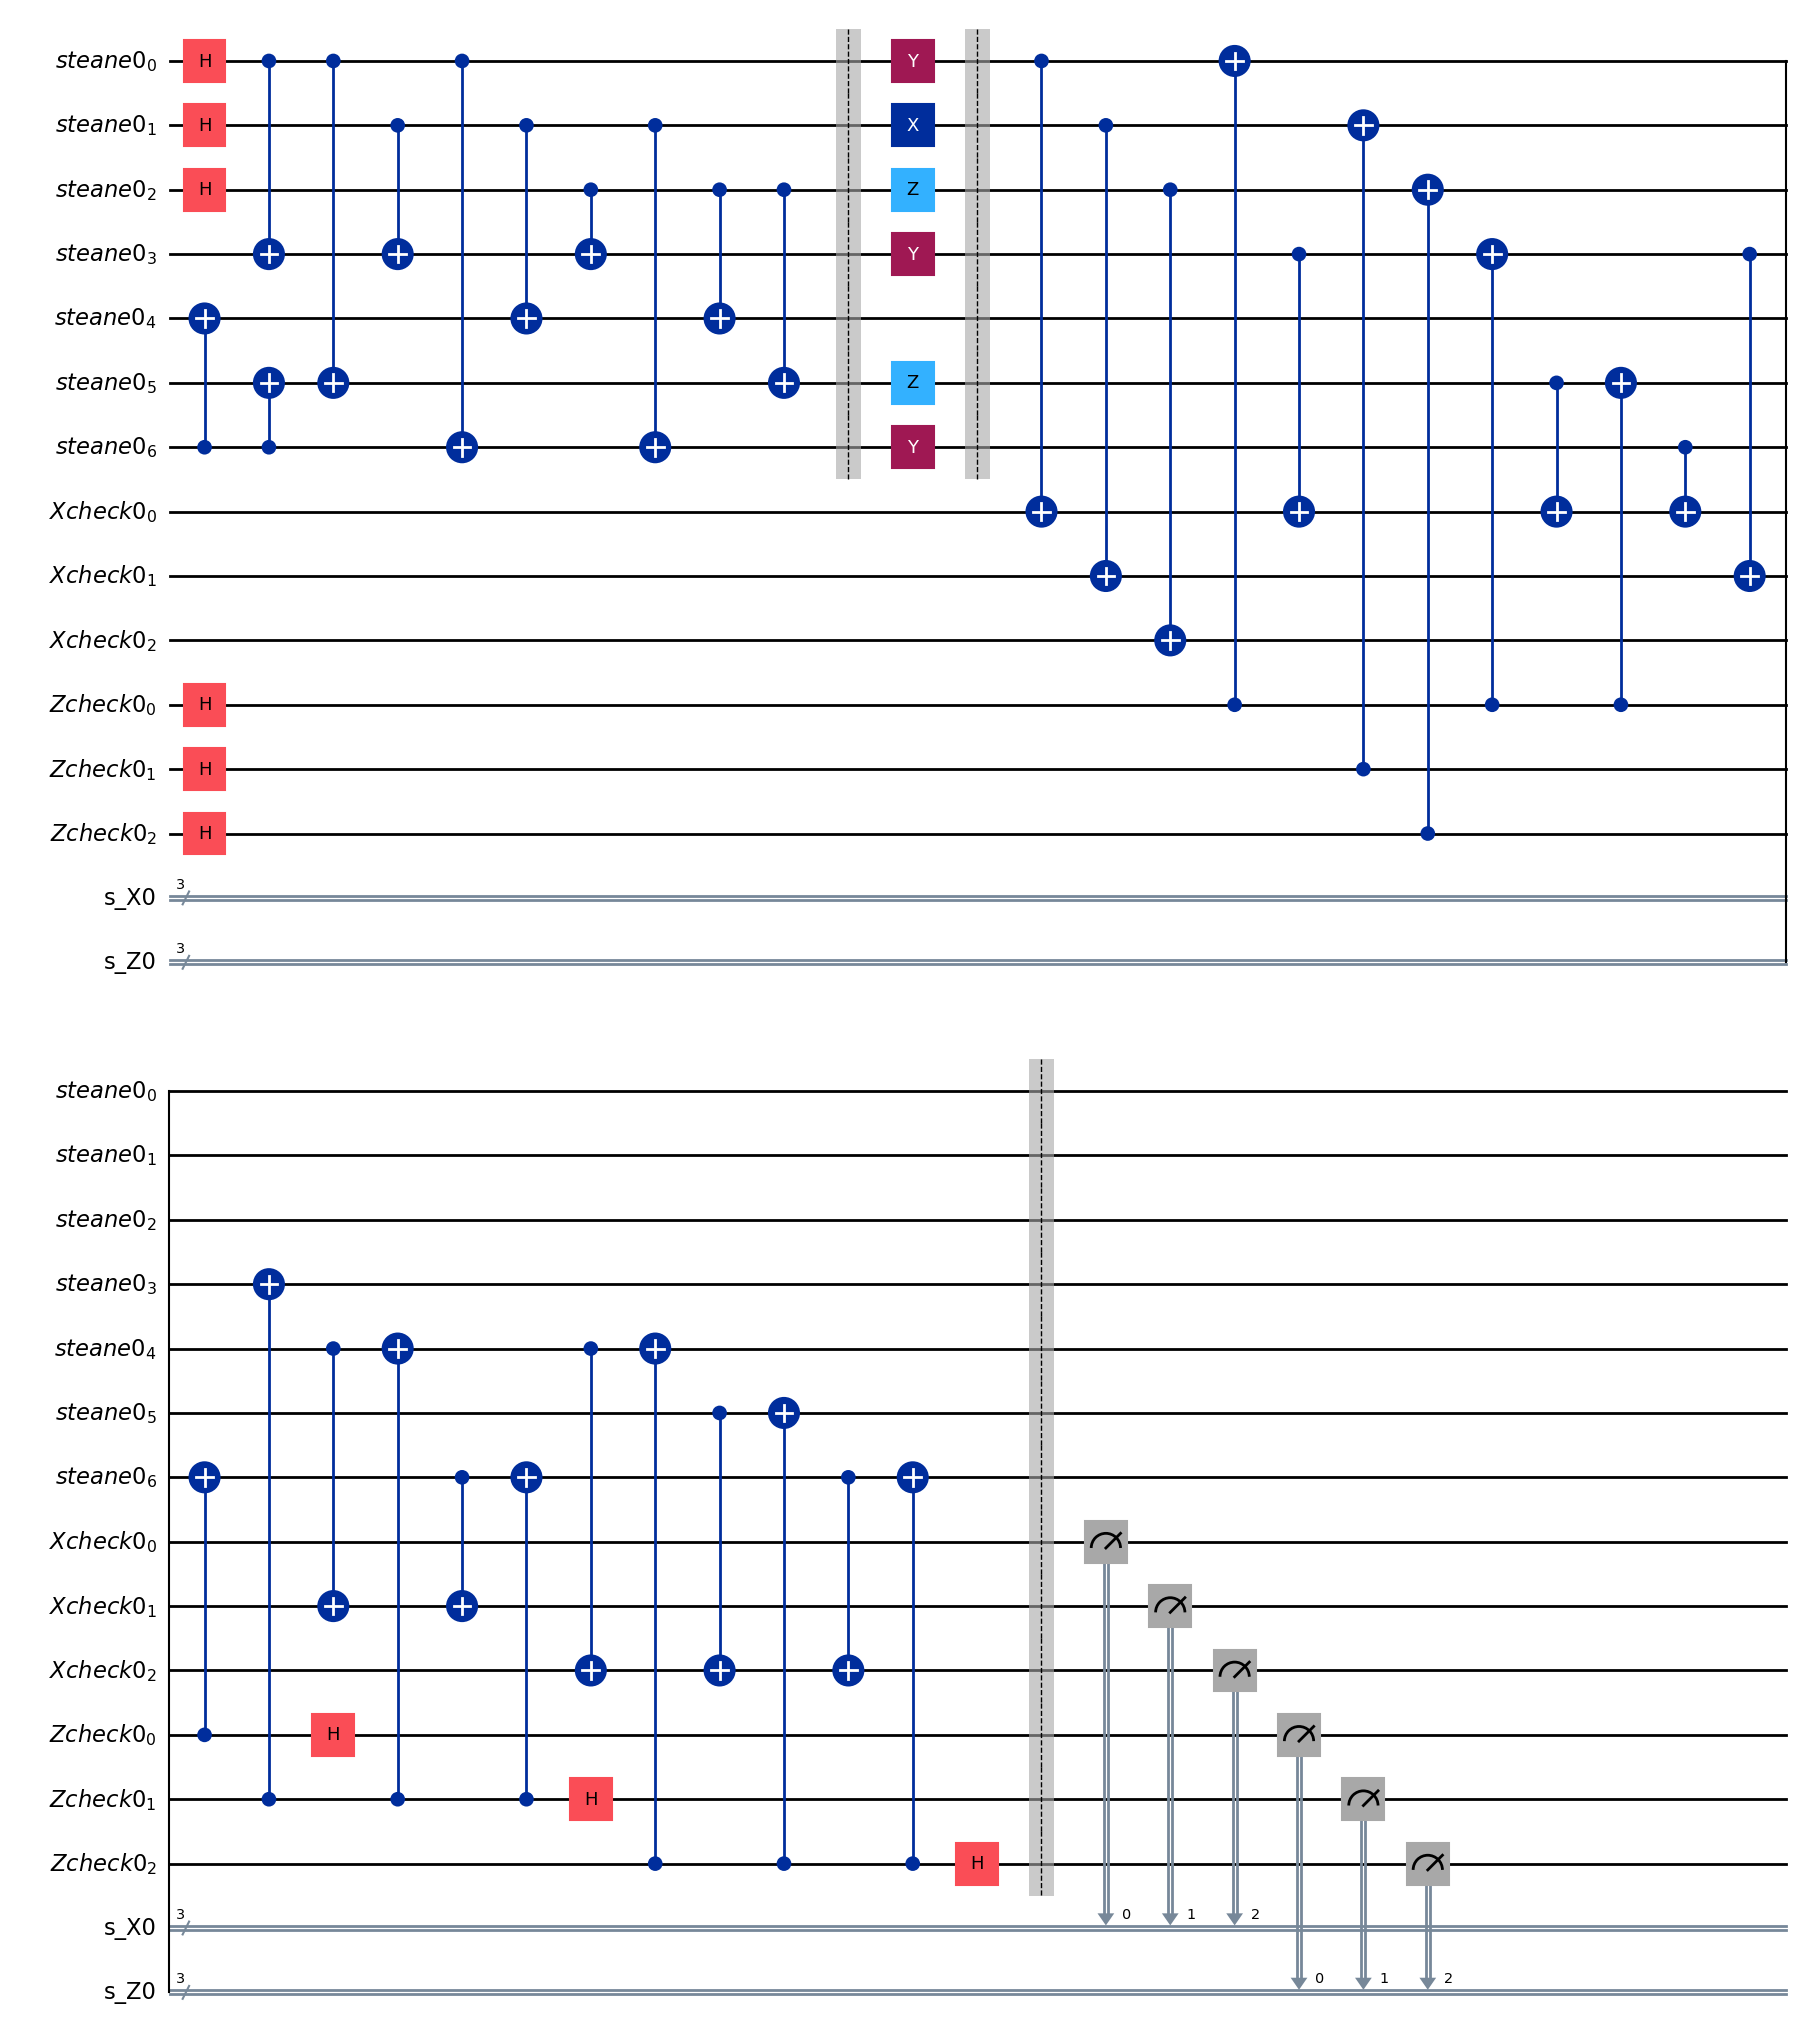

In [4]:
# parity check matrix
H = np.array([[1, 0, 0, 1, 0, 1, 1],
                [0, 1, 0, 1, 1, 0, 1],
                [0, 0, 1, 0, 1, 1, 1]])

# syndrome extraction
def syndrome_extraction(steane_qubits, steane_code, H):
    for block_index, block in enumerate(steane_qubits):
        # create ancillas for each block to extract syndromes
        qubits_for_X_checks = AncillaRegister(3, name=f"Xcheck{block_index}")
        qubits_for_Z_checks = AncillaRegister(3, name=f"Zcheck{block_index}")
        # create classical bits for storing syndrome measurements
        X_syndromes = ClassicalRegister(3, name=f"s_X{block_index}")
        Z_syndromes = ClassicalRegister(3, name=f"s_Z{block_index}")
        steane_code.add_register(qubits_for_X_checks, qubits_for_Z_checks, X_syndromes, Z_syndromes)

        # extract syndromes
        for idx, row in enumerate(H):
            steane_code.h(qubits_for_Z_checks[idx])
            for qubit_index in np.where(row)[0]:
                steane_code.cx(block[qubit_index], qubits_for_X_checks[idx]) # X check
                steane_code.cx(qubits_for_Z_checks[idx], block[qubit_index]) # Z check
            steane_code.h(qubits_for_Z_checks[idx])
        steane_code.barrier()

        # measure
        steane_code.measure(qubits_for_X_checks, X_syndromes)
        steane_code.measure(qubits_for_Z_checks, Z_syndromes)
           
steane_code = QuantumCircuit(*steane_qubits, name="steane_circuit")
encode(xstring, steane_qubits, steane_code)
steane_code.barrier()
error(p, steane_qubits, steane_code) 
steane_code.barrier()
syndrome_extraction(steane_qubits, steane_code, H)
steane_code.draw(output="mpl")

### Correcting 1 Qubit Errors and Decoding

With the information where there are 1 qubit errors, we now apply recovery operations to fix them, decode and measure the data qubits to see how the recovery went. We use conditional corrections based on the measured X,Z syndromes. If a syndrome indicates an X error on qubit i, apply an X gate to correct it. If a syndrome indicates a Z error on qubit i, apply a Z gate to correct it.

Qubit <Qubit register=(7, "steane0"), index=0>: No error applied
Qubit <Qubit register=(7, "steane0"), index=1>: Y error applied
Qubit <Qubit register=(7, "steane0"), index=2>: X error applied
Qubit <Qubit register=(7, "steane0"), index=3>: No error applied
Qubit <Qubit register=(7, "steane0"), index=4>: Y error applied
Qubit <Qubit register=(7, "steane0"), index=5>: Y error applied
Qubit <Qubit register=(7, "steane0"), index=6>: No error applied


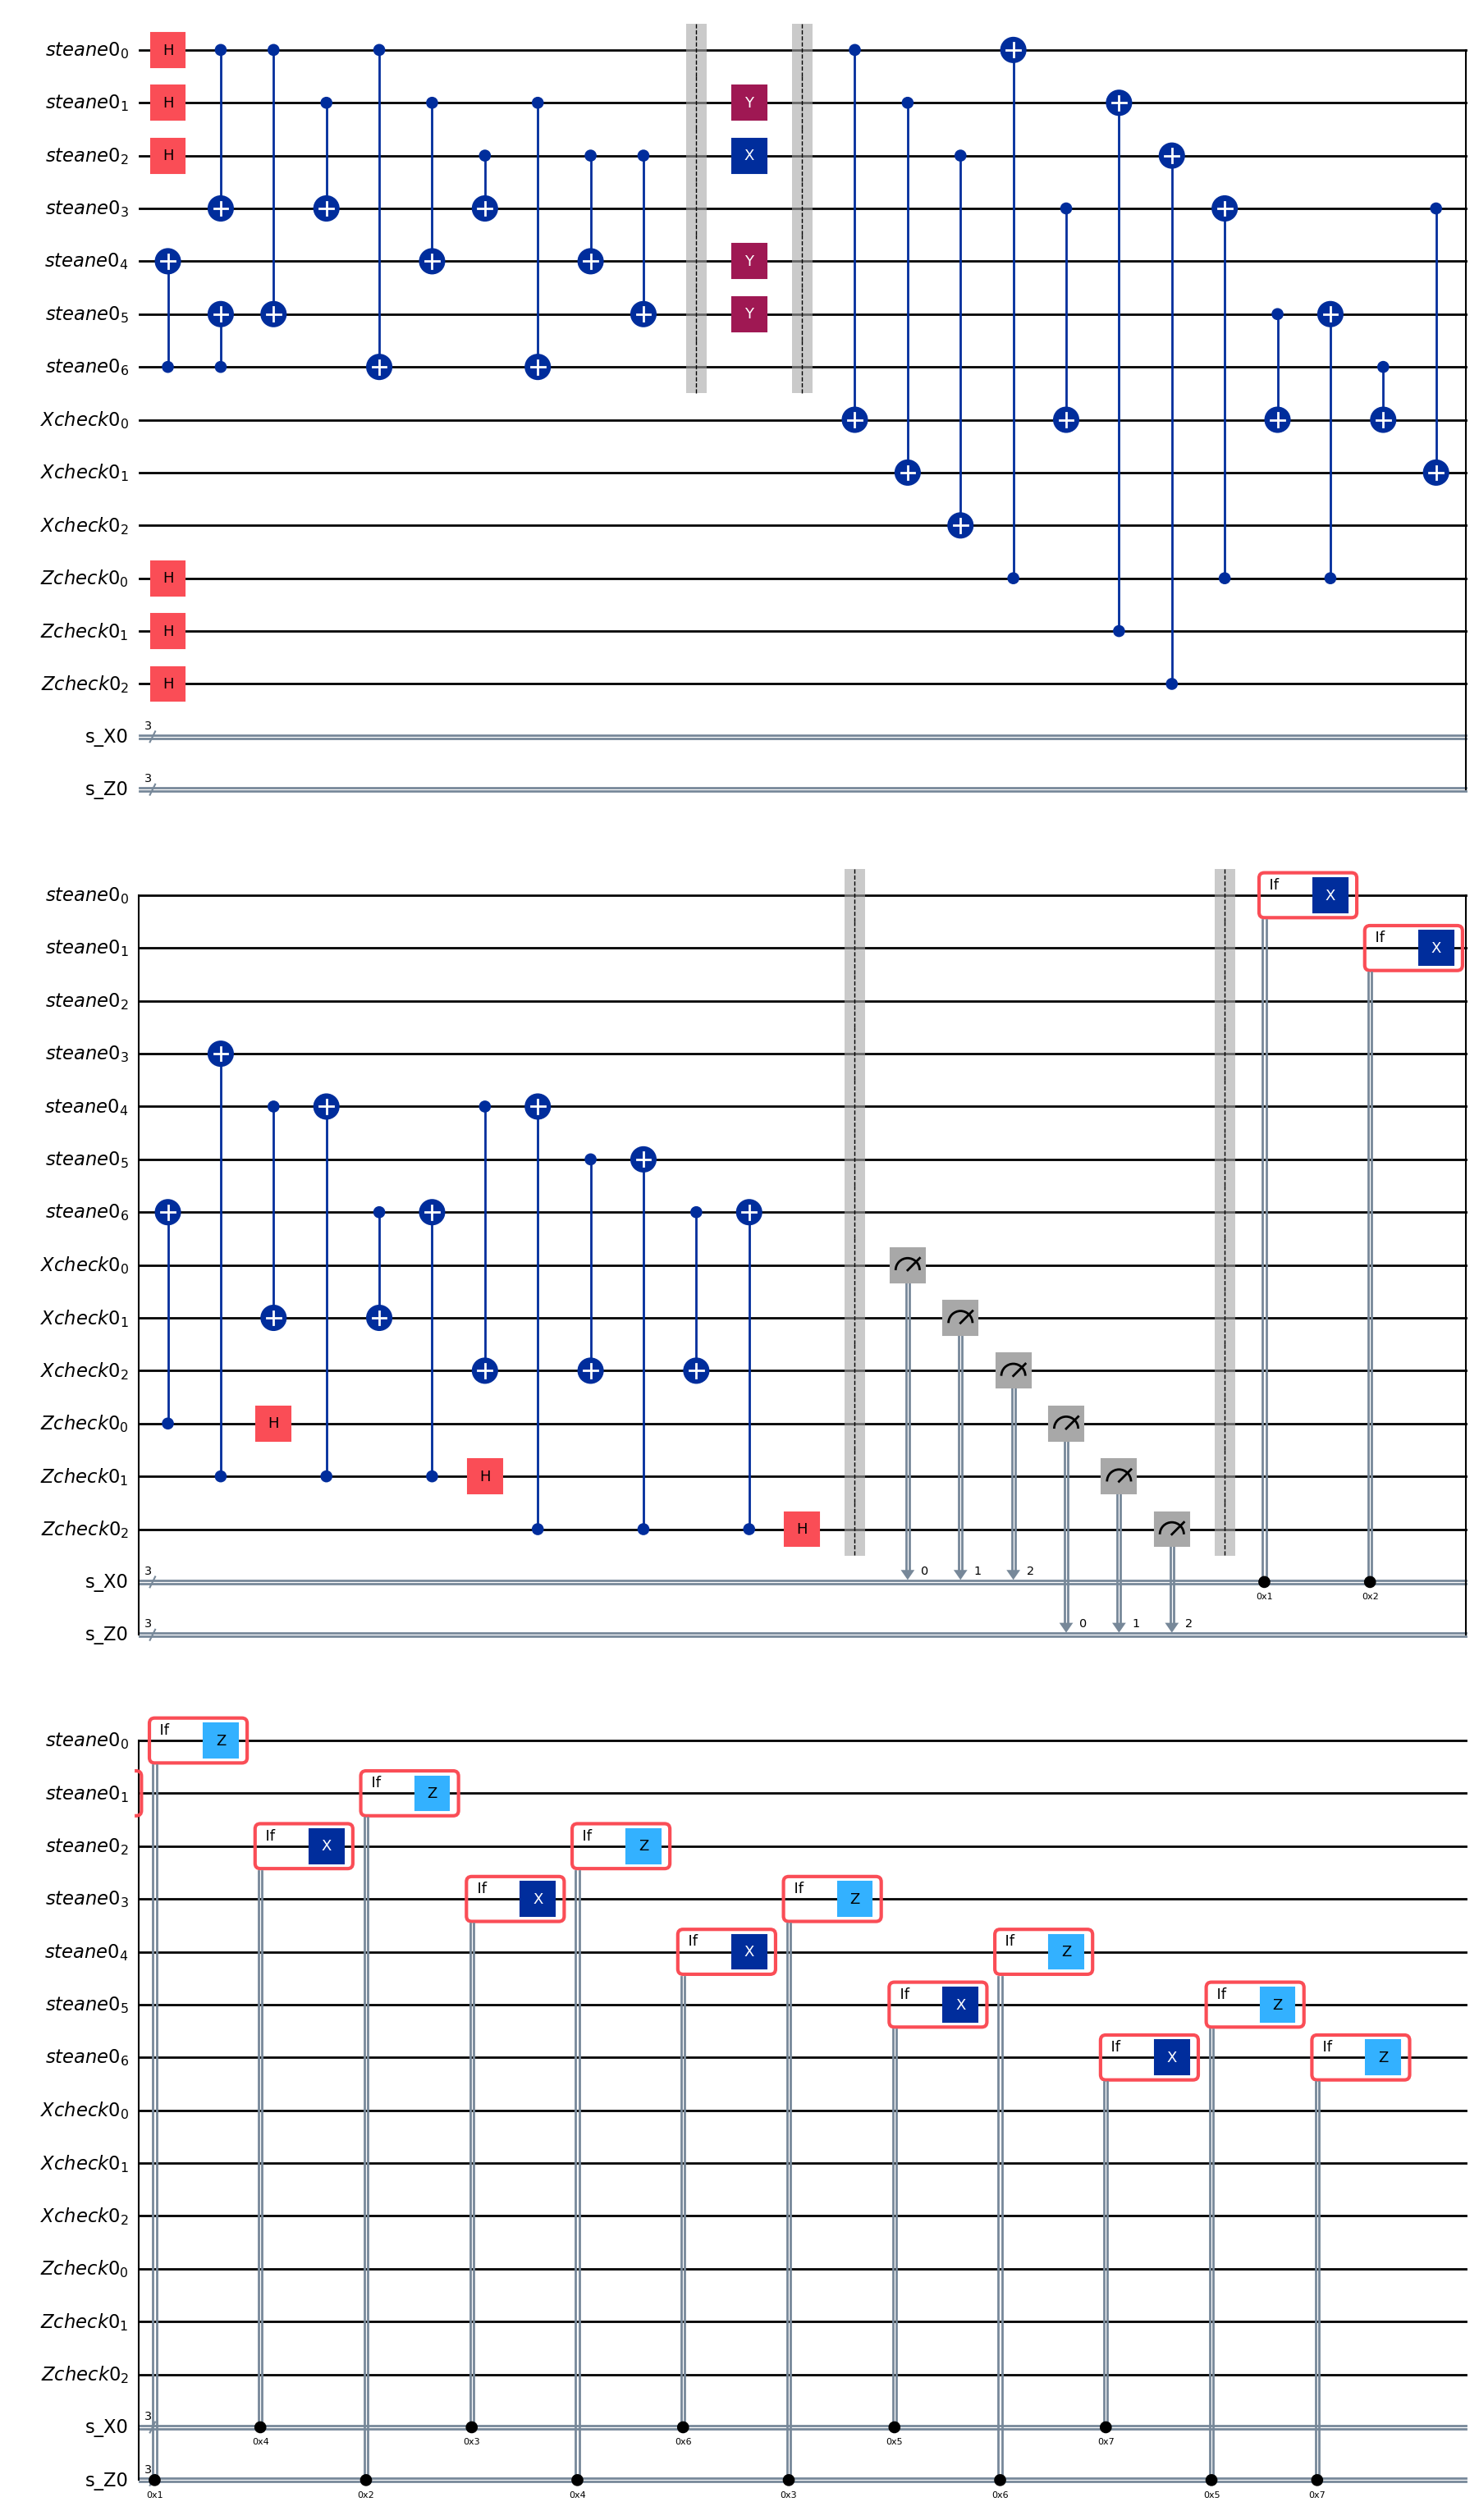

In [5]:
def correction(steane_qubits, steane_code):
    # error correction
    for block_index, block in enumerate(steane_qubits):
        # the classical registers
        X_syndromes = ClassicalRegister(3, name=f"s_X{block_index}")
        Z_syndromes = ClassicalRegister(3, name=f"s_Z{block_index}")

        # add the X checks
        with steane_code.if_test((X_syndromes, 1)):
            steane_code.x(block[0])

        with steane_code.if_test((X_syndromes, 2)):
            steane_code.x(block[1])

        with steane_code.if_test((X_syndromes, 4)):
            steane_code.x(block[2])

        with steane_code.if_test((X_syndromes, 3)):
            steane_code.x(block[3])

        with steane_code.if_test((X_syndromes, 6)):
            steane_code.x(block[4])

        with steane_code.if_test((X_syndromes, 5)):
            steane_code.x(block[5])

        with steane_code.if_test((X_syndromes, 7)):
            steane_code.x(block[6])

        # add the Z checks
        with steane_code.if_test((Z_syndromes, 1)):
            steane_code.z(block[0])

        with steane_code.if_test((Z_syndromes, 2)):
            steane_code.z(block[1])

        with steane_code.if_test((Z_syndromes, 4)):
            steane_code.z(block[2])

        with steane_code.if_test((Z_syndromes, 3)):
            steane_code.z(block[3])

        with steane_code.if_test((Z_syndromes, 6)):
            steane_code.z(block[4])

        with steane_code.if_test((Z_syndromes, 5)):
            steane_code.z(block[5])

        with steane_code.if_test((Z_syndromes, 7)):
            steane_code.z(block[6])
              
steane_code = QuantumCircuit(*steane_qubits, name="steane_circuit")
encode(xstring, steane_qubits, steane_code)
steane_code.barrier()
error(p, steane_qubits, steane_code)
steane_code.barrier()
syndrome_extraction(steane_qubits, steane_code, H)
steane_code.barrier()
correction(steane_qubits, steane_code)
steane_code.draw(output="mpl")

Now we decode and measure our data qubits. If the data qubits are in the all zero state, then the error correction was successful.

Qubit <Qubit register=(7, "steane0"), index=0>: Y error applied
Qubit <Qubit register=(7, "steane0"), index=1>: Z error applied
Qubit <Qubit register=(7, "steane0"), index=2>: No error applied
Qubit <Qubit register=(7, "steane0"), index=3>: Y error applied
Qubit <Qubit register=(7, "steane0"), index=4>: No error applied
Qubit <Qubit register=(7, "steane0"), index=5>: No error applied
Qubit <Qubit register=(7, "steane0"), index=6>: X error applied


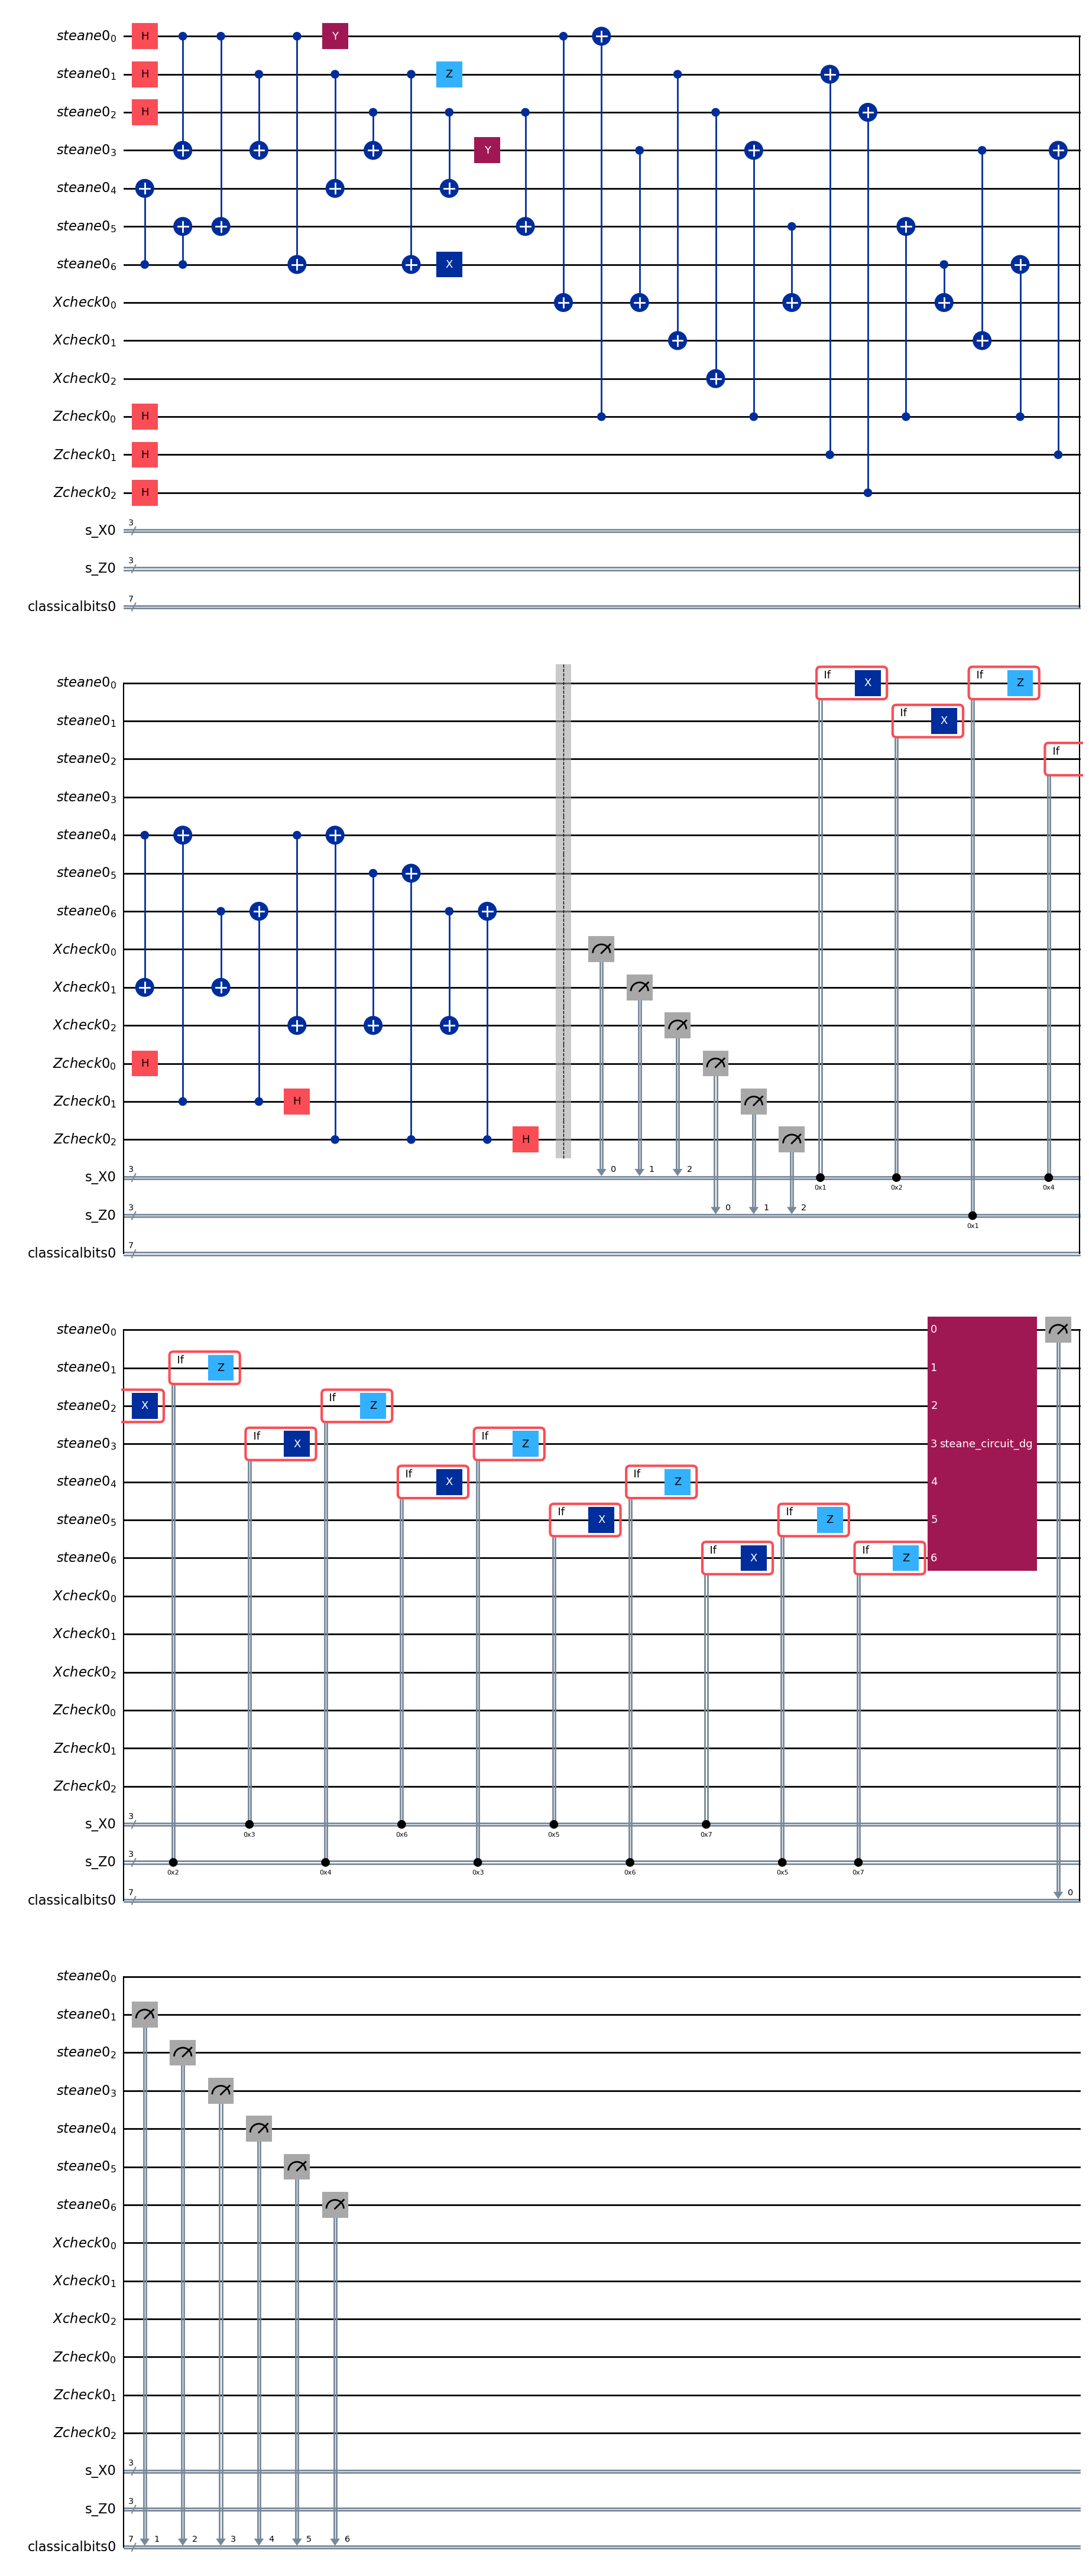

In [6]:
# decoding the circuit back to the original all zeros state

def decompose_measure(xstring, steane_qubits, steane_code):
    steane_code.compose(encoder.inverse().to_instruction(), inplace=True)

    for block_index, block in enumerate(steane_qubits):
        # Create classical registers
        classical_bits = ClassicalRegister(7, name=f"classicalbits{block_index}")
        steane_code.add_register(classical_bits)

        # Measure each qubit in this block into the corresponding classical bit
        for i in range(7):
            steane_code.measure(block[i], classical_bits[i])
              
steane_code = QuantumCircuit(*steane_qubits, name="steane_circuit")
encode(xstring, steane_qubits, steane_code)
error(p, steane_qubits, steane_code)     
syndrome_extraction(steane_qubits, steane_code, H)
correction(steane_qubits, steane_code)
decompose_measure(xstring, steane_qubits, steane_code)
display(steane_code.draw(output="mpl"))

Let us use Qiskit's AerSimulator to how how our Steane's code perform. 

In [7]:
simulator = AerSimulator()

In [8]:
rounds = 200
# Transpile the circuit for the backend
compiled_circuit = transpile(steane_code, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=rounds)

# Get the measurement counts
counts = job.result().get_counts()

In [12]:
distribution = {}
for measurement in counts:
    if measurement[:7] in distribution:
        distribution[measurement[:7]] += counts[measurement] / rounds
    else:
        distribution[measurement[:7]] = counts[measurement] / rounds

distribution

{'0000000': 0.18,
 '1111000': 0.16,
 '0111100': 0.14,
 '0000100': 0.22,
 '0111000': 0.08,
 '1111100': 0.08,
 '1000100': 0.1,
 '1000000': 0.04}

# Success Probability

In this section, we take the single qubit basis state $|0>$ and run it through Steane's code to see how the success probability changes for various values of $p$. The success probability is defined as the probability of measuring the logical all-zero single qubit state $|0_L>$ at the end.

Qubit <Qubit register=(7, "steane0"), index=0>: No error applied
Qubit <Qubit register=(7, "steane0"), index=1>: No error applied
Qubit <Qubit register=(7, "steane0"), index=2>: No error applied
Qubit <Qubit register=(7, "steane0"), index=3>: No error applied
Qubit <Qubit register=(7, "steane0"), index=4>: No error applied
Qubit <Qubit register=(7, "steane0"), index=5>: No error applied
Qubit <Qubit register=(7, "steane0"), index=6>: No error applied
{'1000100': 0.18000000000000002, '0111000': 0.16, '0111100': 0.1, '0000000': 0.16, '1111100': 0.12, '0000100': 0.1, '1111000': 0.06, '1000000': 0.12}
Qubit <Qubit register=(7, "steane0"), index=0>: No error applied
Qubit <Qubit register=(7, "steane0"), index=1>: No error applied
Qubit <Qubit register=(7, "steane0"), index=2>: No error applied
Qubit <Qubit register=(7, "steane0"), index=3>: No error applied
Qubit <Qubit register=(7, "steane0"), index=4>: Z error applied
Qubit <Qubit register=(7, "steane0"), index=5>: No error applied
Qubit 

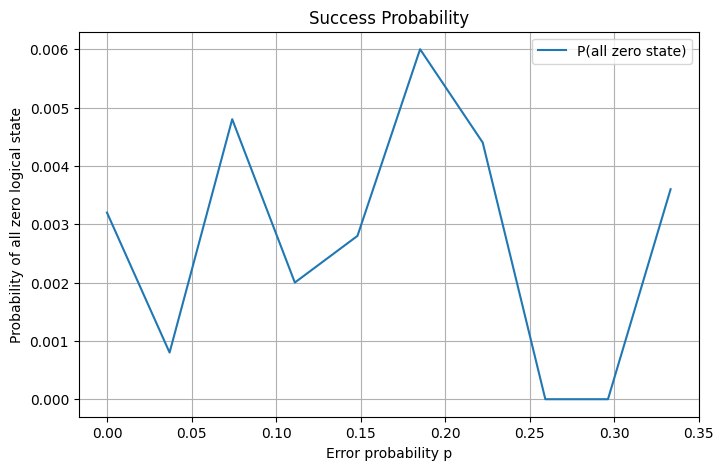

In [11]:
# define s set of p values
p_values = np.linspace(0, 1/3, 10)
prob_all_zero = []

# simulate over set of p values
for pp in p_values:

    steane_code = QuantumCircuit(*steane_qubits, name="steane_circuit")
    encode(xstring, steane_qubits, steane_code)
    error(pp, steane_qubits, steane_code)     
    syndrome_extraction(steane_qubits, steane_code, H)
    correction(steane_qubits, steane_code)
    decompose_measure(xstring, steane_qubits, steane_code)
    
    rounds = 50
    # Transpile the circuit for the backend
    compiled_circuit = transpile(steane_code, simulator)
    # Run the circuit
    job = simulator.run(compiled_circuit, shots=rounds)
    # Get the measurement counts
    counts = job.result().get_counts()

    distribution = {}
    for measurement in counts:
        if measurement[:7] in distribution:
            distribution[measurement[:7]] += counts[measurement] / rounds
        else:
            distribution[measurement[:7]] = counts[measurement] / rounds

    print(distribution)
    
    # probability of all zero logical state
    prob = distribution.get('0000000', 0)/rounds
    prob_all_zero.append(prob)

# plotting
plt.figure(figsize=(8, 5))
plt.plot(p_values, prob_all_zero, label="P(all zero state)")
plt.xlabel("Error probability p")
plt.ylabel("Probability of all zero logical state")
plt.title("Success Probability")
plt.grid(True)
plt.legend()
plt.show()

# References

[1] Steane, A., Error Correcting Codes in Quantum Theory, Physical Review Letters, 77(5), (1996).

[2] Nakahara, M. and Ohmi T., Quantum Computing From Linear Algebra to Physical Realizations, CRC Press, (2008).

[3] https://abdullahkhalid.com/qecft/stabilizer-codes/encoding-circuits-for-stabilizer-codes/